Step 1: Preprocess the Text Data (Title Column)

Tokenization: Split each article title into individual words.
Vocabulary Creation: Create a vocabulary from all unique words in the titles and assign each word a unique ID.
Padding: Ensure each title has the same length by padding shorter titles or truncating longer ones.

In [6]:
import pandas as pd
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import numpy as np
import torch

In [7]:


# Load the dataset from Parquet file
dataset_path_parquet = './final_dataset.parquet'
df = pd.read_parquet(dataset_path_parquet, engine='pyarrow')

# Extract titles for tokenization
titles = df['title'].astype(str).tolist()

# Step 1: Tokenize titles using BPE with reduced vocab size
# Save titles to a temporary file to train BPE model
with open("titles.txt", "w", encoding="utf-8") as f:
    for title in titles:
        f.write(title + "\n")

# Train BPE model on the titles with reduced vocab size
spm.SentencePieceTrainer.train(input="titles.txt", model_prefix="bpe", vocab_size=4500)

# Load BPE model
sp = spm.SentencePieceProcessor(model_file="bpe.model")

# Tokenize titles and build vocabulary
def tokenize_title(title):
    return sp.encode(title, out_type=int)

# Tokenize all titles
tokenized_titles = [tokenize_title(title) for title in titles]


In [8]:

# Step 2: Padding or truncating tokenized titles to a fixed length
max_length = 20  # Example fixed length, adjust as needed
padded_titles = np.zeros((len(tokenized_titles), max_length), dtype=int)

for i, tokens in enumerate(tokenized_titles):
    # Truncate if tokens exceed max_length
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    # Pad if tokens are fewer than max_length
    padded_titles[i, :len(tokens)] = tokens

# Split the dataset into training and validation sets
train_titles, val_titles = train_test_split(padded_titles, test_size=0.2, random_state=42)


In [9]:
#Step 1.5 define the distribution of the tokenized title lengths 

import numpy as np

# Step 1: Calculate the length of each tokenized title
title_lengths = [len(tokenized_title) for tokenized_title in tokenized_titles]

# Step 2: Analyze the distribution of lengths
mean_length = np.mean(title_lengths)
median_length = np.median(title_lengths)
percentile_90 = np.percentile(title_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(title_lengths, 95)  # 95th percentile

# Step 3: Choose a max_length based on the distribution
# You can choose either of these as `max_length`:
# max_length = int(mean_length)  # Option 1: Use the mean length
# max_length = int(median_length)  # Option 2: Use the median length
max_length = int(percentile_90)  # Option 3: Use the 90th percentile

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"90th Percentile: {percentile_90}")
print(f"95th Percentile: {percentile_95}")
print(f"Selected Max Length: {max_length}")

# Step 4: Pad or truncate the titles based on the selected max_length
padded_titles = np.zeros((len(tokenized_titles), max_length), dtype=int)
for i, tokenized_title in enumerate(tokenized_titles):
    length = min(len(tokenized_title), max_length)
    padded_titles[i, :length] = tokenized_title[:length]


Mean Length: 11.541261743229105
Median Length: 11.0
90th Percentile: 16.0
95th Percentile: 18.0
Selected Max Length: 16


Based on the above it makes sense that the max length variable is 20

In [11]:
import zipfile
from huggingface_hub import hf_hub_download
from pathlib import Path
from tqdm import tqdm
from typing import Tuple, List
import torch
import tokenizers
import rich

# Load GloVe embeddings
def load_glove_vectors(filename="glove.6B.300d.txt") -> Tuple[List[str], torch.Tensor]:
    """
    Load the GloVe vectors and parse vocabulary and vectors.

    Args:
        filename (str): Name of the GloVe file to load.

    Returns:
        vocabulary (List[str]): List of words in the GloVe vocabulary.
        vectors (torch.Tensor): Tensor of embedding vectors.
    """
    # Download GloVe file from Hugging Face hub
    path = Path(hf_hub_download(repo_id="stanfordnlp/glove", filename="glove.6B.zip"))
    target_file = path.parent / filename

    # Extract GloVe file if not already extracted
    if not target_file.exists():
        with zipfile.ZipFile(path, "r") as zip_ref:
            zip_ref.extractall(path.parent)

        # Ensure target file exists after extraction
        if not target_file.exists():
            print("Available files:")
            for p in path.parent.iterdir():
                print(p)
            raise ValueError(
                f"Target file `{target_file.name}` can't be found. Check if `{filename}` was properly downloaded."
            )

    # Parse vocabulary and vectors
    vocabulary = []
    vectors = []
    with open(target_file, "r", encoding="utf8") as f:
        for line in tqdm(f.readlines(), desc=f"Parsing {target_file.name}..."):
            word, *vector = line.split()
            vocabulary.append(word)
            vectors.append(torch.tensor([float(v) for v in vector], dtype=torch.float32))
    vectors = torch.stack(vectors)
    return vocabulary, vectors



In [12]:

# Prepare data
glove_vocabulary, glove_vectors = load_glove_vectors()
rich.print(f"glove_vocabulary: type={type(glove_vocabulary)}, length={len(glove_vocabulary)}")
rich.print(f"glove_vectors: type={type(glove_vectors)}, shape={glove_vectors.shape}, dtype={glove_vectors.dtype}")

# Add special tokens
special_tokens = ['<|start|>', '<|unknown|>', '<|pad|>']
glove_vocabulary = special_tokens + glove_vocabulary
glove_vectors = torch.cat([torch.randn(len(special_tokens), glove_vectors.shape[1]), glove_vectors])

# Tokenizer for GloVe
glove_tokenizer = tokenizers.Tokenizer(
    tokenizers.models.WordLevel(vocab={v: i for i, v in enumerate(glove_vocabulary)}, unk_token="<|unknown|>")
)
glove_tokenizer.normalizer = tokenizers.normalizers.BertNormalizer(strip_accents=False)
glove_tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.Whitespace()

# Test Tokenizer
example_text = "This is an example sentence for testing."
encoded = glove_tokenizer.encode(example_text)
rich.print(f"Encoded tokens: {encoded.tokens}")
rich.print(f"Token IDs: {encoded.ids}")

Parsing glove.6B.300d.txt...: 100%|██████████| 400001/400001 [00:29<00:00, 13608.10it/s]


glove_vocabulary: type=<class 'list'>, length=400001

glove_vectors: type=<class 'torch.Tensor'>, shape=torch.Size([400001, 300]), dtype=torch.float32

Encoded tokens: ['this', 'is', 'an', 'example', 'sentence', 'for', 'testing', '.']

Token IDs: [40, 17, 32, 883, 2425, 13, 2577, 5]

In [13]:
# Tokenize the titles
encoded_titles = [glove_tokenizer.encode(title).ids for title in titles]

# Determine the maximum length for padding (adjust based on your dataset)
max_length = 20  # Modify if your titles are generally longer or shorter

# Pad or truncate the tokenized titles
padded_titles = torch.zeros((len(encoded_titles), max_length), dtype=torch.long)
for i, encoded in enumerate(encoded_titles):
    length = min(len(encoded), max_length)
    padded_titles[i, :length] = torch.tensor(encoded[:length])


In [14]:
from sklearn.model_selection import train_test_split

# Prepare the titles (already tokenized and padded)
titles = df['title'].fillna('').tolist()
encoded_titles = [glove_tokenizer.encode(title).ids for title in titles]

# Padding the tokenized titles
padded_titles = torch.zeros((len(encoded_titles), max_length), dtype=torch.long)
for i, encoded in enumerate(encoded_titles):
    length = min(len(encoded), max_length)
    padded_titles[i, :length] = torch.tensor(encoded[:length])

# Split into train and validation sets
train_data, val_data = train_test_split(padded_titles, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.long)
val_data = torch.tensor(val_data, dtype=torch.long)


C:\Users\antot\AppData\Local\Temp\ipykernel_34404\741470256.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_data, dtype=torch.long)
C:\Users\antot\AppData\Local\Temp\ipykernel_34404\741470256.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = torch.tensor(val_data, dtype=torch.long)


Step 2: Set Up the Word Embedding Layer
Embedding Matrix: Initialize an embedding matrix to convert each word ID into a dense vector representation.
Pre-trained Embeddings (Optional): If available, load pre-trained embeddings (e.g., GloVe) to initialize the embedding layer.

Step-by-Step Code for the Embedding Layer in TensorFlow
Define the Embedding Layer:

We’ll use TensorFlow’s Embedding layer, initializing it with the embedding_matrix.
Set trainable=False to prevent the GloVe embeddings from being updated during training, or trainable=True if you'd like to allow fine-tuning.
Integrate the Embedding Layer into the News Encoder:

The News Encoder will now use this embedding layer to transform word IDs (tokenized titles) into dense vectors.

Steps for Multi-Head Self-Attention
Scaled Dot-Product Attention:

Compute the attention scores between each pair of words.
Scale the dot product by the square root of the dimension size to avoid large values.
Apply softmax to normalize these scores and generate attention weights.
Use these weights to compute a weighted sum of the values for each word.
Multiple Attention Heads:

Create multiple independent attention heads to learn different aspects of relationships between words.
Each head has its own projection matrices for queries, keys, and values.
Concatenate the Heads:

Concatenate the outputs of all heads to get the final representation for each word.
Linear Layer for Multi-Head Output:

Optionally, apply a linear transformation to combine the outputs from different heads.

Made your code pytorch and added the formulas as mentioned in the paper

Steps to Implement the Additive Attention Layer
Compute Attention Scores:

For each word representation, calculate an attention score based on its importance.
Apply Softmax:

Use softmax to normalize the scores across all words in the title so that they sum to 1. This gives us attention weights.
Weighted Sum:

Use the attention weights to compute a weighted sum of the word representations, resulting in a single vector that represents the entire title.

News Encoder Class Structure
Embedding Layer:

Converts tokenized word IDs into dense embeddings using the GloVe-initialized embedding layer.
Multi-Head Self-Attention Layer:

Captures interactions between words in the title.
Additive Attention Layer:

Determines the importance of each word in the title and computes a weighted sum to produce a single representation for the entire title.

-------------------------------------------------

## News Encoder Architecture

In [15]:
# Hyperparameters
embed_dim = 300  # GloVe embedding dimension
num_heads = 15  # Number of attention heads
head_dim = 16  # Output dimension per head
output_dim = num_heads * head_dim  # Total embedding dimension for self-attention
query_vector_dim = 200  # Additive attention query vector dimension
vocab_size = 4500  # Vocabulary size
max_length = 20  # Maximum sequence length

import torch
import torch.nn as nn
import torch.nn.functional as F

# Word Embedding Layer
class WordEmbeddings(nn.Module):
    def __init__(self, embedding_matrix):
        super(WordEmbeddings, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True  # Set to False to fine-tune embeddings
        )

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        return embeddings

# Self-Attention Layer
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        """
        Multi-Head Self-Attention based on the provided formulas.

        Args:
            embed_dim (int): Embedding dimension of the input.
            num_heads (int): Number of self-attention heads.
        """
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Separate Query and Value projection matrices for each head
        self.query_matrices = nn.Parameter(torch.randn(num_heads, self.head_dim, self.head_dim))
        self.value_matrices = nn.Parameter(torch.randn(num_heads, self.head_dim, self.head_dim))

    def forward(self, inputs):
        """
        Args:
            inputs: Tensor of shape (batch_size, seq_len, embed_dim).

        Returns:
            output: Tensor of shape (batch_size, seq_len, embed_dim).
            attention_weights: Tensor of shape (batch_size, num_heads, seq_len, seq_len).
        """
        batch_size, seq_len, _ = inputs.size()

        # Reshape input for multi-head computation
        inputs = inputs.view(batch_size, seq_len, self.num_heads, self.head_dim)
        inputs = inputs.permute(0, 2, 1, 3)  # Shape: (batch_size, num_heads, seq_len, head_dim)

        attention_outputs = []
        attention_weights_all_heads = []

        for k in range(self.num_heads):
            # Compute attention scores for head k
            Q_k = self.query_matrices[k]  # Shape: (head_dim, head_dim)
            attention_scores = torch.einsum('bqi,qk,bqj->bij', inputs[:, k, :, :], Q_k, inputs[:, k, :, :])
            attention_weights = F.softmax(attention_scores, dim=-1)  # Shape: (batch_size, seq_len, seq_len)

            # Compute weighted sum for head k
            weighted_sum = torch.einsum('bij,bjd->bid', attention_weights, inputs[:, k, :, :])  # (batch_size, seq_len, head_dim)

            # Apply value projection
            V_k = self.value_matrices[k]  # Shape: (head_dim, head_dim)
            weighted_output = torch.einsum('bqd,dk->bqk', weighted_sum, V_k)  # Shape: (batch_size, seq_len, head_dim)

            attention_outputs.append(weighted_output)
            attention_weights_all_heads.append(attention_weights)

        # Concatenate outputs from all heads
        concat_output = torch.cat(attention_outputs, dim=-1)  # Shape: (batch_size, seq_len, embed_dim)

        # Stack attention weights for all heads
        attention_weights_all_heads = torch.stack(attention_weights_all_heads, dim=1)  # Shape: (batch_size, num_heads, seq_len, seq_len)

        return concat_output, attention_weights_all_heads


class AdditiveWordAttention(nn.Module):
    """
    Implements Additive Word Attention for selecting important words
    to learn a more informative representation of news titles.
    """
    def __init__(self, embed_dim, query_dim):
        """
        Additive Word Attention Network.

        Args:
            embed_dim (int): Dimensionality of the input embeddings (h_w).
            query_dim (int): Dimensionality of the query vector (q_w).
        """
        super(AdditiveWordAttention, self).__init__()
        self.embed_dim = embed_dim
        self.query_dim = query_dim

        # Learnable parameters for attention
        self.Vw = nn.Linear(embed_dim, query_dim, bias=True)  # Linear projection matrix
        self.vw = nn.Parameter(torch.randn(query_dim))        # Bias vector vw
        self.qw = nn.Parameter(torch.randn(query_dim))        # Query vector qw

    def forward(self, inputs):
        """
        Compute word-level additive attention.

        Args:
            inputs (torch.Tensor): Tensor of shape (batch_size, seq_len, embed_dim), 
                                   contextual word representations (h_w).

        Returns:
            weighted_sum (torch.Tensor): Tensor of shape (batch_size, embed_dim), 
                                         final news representation as a weighted sum.
            attention_weights (torch.Tensor): Tensor of shape (batch_size, seq_len), 
                                              attention weights for each word.
        """
        # Step 1: Linear projection to transform inputs into attention space
        projection = self.Vw(inputs)  # Shape: (batch_size, seq_len, query_dim)

        # Step 2: Add the bias vector (vw) to the projection
        projection_with_bias = projection + self.vw  # Shape: (batch_size, seq_len, query_dim)

        # Step 3: Apply tanh activation to introduce non-linearity
        scores = torch.tanh(projection_with_bias)  # Shape: (batch_size, seq_len, query_dim)

        # Step 4: Compute raw attention scores via dot product with the query vector (qw)
        attention_scores = torch.matmul(scores, self.qw)  # Shape: (batch_size, seq_len)

        # Step 5: Normalize the attention scores to probabilities using softmax
        attention_weights = F.softmax(attention_scores, dim=1)  # Shape: (batch_size, seq_len)

        # Step 6: Compute the weighted sum of the input embeddings based on attention weights
        weighted_sum = torch.sum(inputs * attention_weights.unsqueeze(-1), dim=1)  # Shape: (batch_size, embed_dim)

        # Return the final weighted representation and the attention weights
        return weighted_sum, attention_weights



In [16]:
class NewsEncoder(nn.Module):
    def __init__(self, embedding_matrix, embed_dim, num_heads, query_dim, dropout=0.2):
        super(NewsEncoder, self).__init__()
        self.word_embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.additive_attention = nn.Sequential(
            nn.Linear(embed_dim, query_dim),
            nn.Tanh(),
            nn.Linear(query_dim, 1),
        )
        self.reconstruction_head = nn.Linear(embed_dim, embedding_matrix.size(1))  # To reconstruct embeddings
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        x = self.word_embeddings(inputs)  # Shape: (batch_size, seq_len, embed_dim)
        x = self.dropout(x)

        attn_output, attn_weights = self.self_attention(x, x, x)
        attn_scores = self.additive_attention(attn_output).squeeze(-1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        news_representation = torch.sum(attn_weights.unsqueeze(-1) * attn_output, dim=1)

        reconstructed = self.reconstruction_head(news_representation)  # Reconstruct embeddings
        return reconstructed, attn_weights


In [17]:
# Convert GloVe embeddings to PyTorch tensor
embedding_matrix = glove_vectors  # Assuming `glove_vectors` contains your embedding matrix
embed_dim = embedding_matrix.shape[1]

# Initialize NewsEncoder
num_heads = 15
query_vector_dim = 200
dropout = 0.2

news_encoder = NewsEncoder(
    embedding_matrix=embedding_matrix,
    embed_dim=embed_dim,
    num_heads=num_heads,
    query_dim=query_vector_dim,
    dropout=dropout,
)

print("NewsEncoder initialized with GloVe embeddings.")


NewsEncoder initialized with GloVe embeddings.


## Optimization

In [18]:
# Loss function and optimizer
criterion = nn.MSELoss()  # Replace with your task-specific loss
optimizer = torch.optim.Adam(news_encoder.parameters(), lr=1e-3)

Step 6: Testing and Validation
Input Data: Pass some titles through the News Encoder.
Output: Verify that the encoder produces a consistent representation (vector) for each title.

# Train

In [19]:
embedding_matrix = glove_vectors  # Replace with your embedding matrix
embed_dim = embedding_matrix.size(1)  # Dimension of embeddings
num_heads = 15  # Number of attention heads
query_dim = 200  # Additive attention query vector dimension
dropout = 0.2  # Dropout rate

# Initialize UserEncoder
user_encoder = NewsEncoder(
    embedding_matrix=embedding_matrix,
    embed_dim=embed_dim,
    num_heads=num_heads,
    query_dim=query_dim,
    dropout=dropout,
)

print("NewsEncoder initialized successfully.")

NewsEncoder initialized successfully.


Epoch 1/20 - Batch 1/3477, Loss: 0.0046


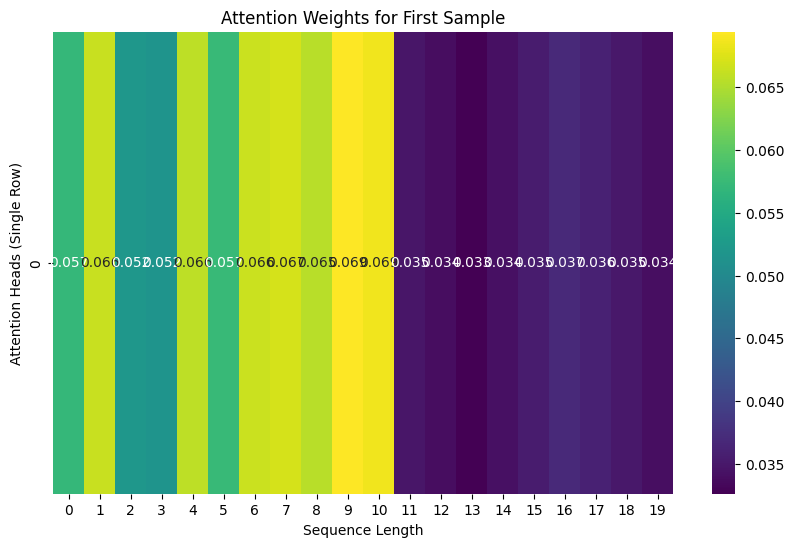

Epoch 1/20 - Batch 2/3477, Loss: 0.0754
Epoch 1/20 - Batch 3/3477, Loss: 0.0384
Epoch 1/20 - Batch 4/3477, Loss: 0.0213
Epoch 1/20 - Batch 5/3477, Loss: 0.0322
Epoch 1/20 - Batch 6/3477, Loss: 0.0245
Epoch 1/20 - Batch 7/3477, Loss: 0.0203
Epoch 1/20 - Batch 8/3477, Loss: 0.0224
Epoch 1/20 - Batch 9/3477, Loss: 0.0158
Epoch 1/20 - Batch 10/3477, Loss: 0.0133
Epoch 1/20 - Batch 11/3477, Loss: 0.0152
Epoch 1/20 - Batch 12/3477, Loss: 0.0156
Epoch 1/20 - Batch 13/3477, Loss: 0.0123
Epoch 1/20 - Batch 14/3477, Loss: 0.0153
Epoch 1/20 - Batch 15/3477, Loss: 0.0104
Epoch 1/20 - Batch 16/3477, Loss: 0.0083
Epoch 1/20 - Batch 17/3477, Loss: 0.0089
Epoch 1/20 - Batch 18/3477, Loss: 0.0086
Epoch 1/20 - Batch 19/3477, Loss: 0.0070
Epoch 1/20 - Batch 20/3477, Loss: 0.0066
Epoch 1/20 - Batch 21/3477, Loss: 0.0071
Epoch 1/20 - Batch 22/3477, Loss: 0.0064
Epoch 1/20 - Batch 23/3477, Loss: 0.0050
Epoch 1/20 - Batch 24/3477, Loss: 0.0058
Epoch 1/20 - Batch 25/3477, Loss: 0.0051
Epoch 1/20 - Batch 26/34

KeyboardInterrupt: 

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming train_data is your tokenized and padded dataset
batch_size = 64  # Batch size
epochs = 20  # Number of epochs

# Create DataLoader
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)

# Loss function and optimizer
criterion = nn.MSELoss()  # Replace this if needed for unsupervised learning
optimizer = torch.optim.Adam(user_encoder.parameters(), lr=1e-3)

# Training loop
for epoch in range(epochs):
    user_encoder.train()  # Set the model to training mode
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = batch[0].to(torch.long)  # Ensure inputs are LongTensor
        representations, attention_weights = user_encoder(inputs)

        # Compute loss (reconstruction, contrastive, etc.)
        loss = criterion(representations, user_encoder.word_embeddings(inputs).mean(dim=1))  # Example reconstruction task
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Print batch progress
        print(
            f"Epoch {epoch + 1}/{epochs} - Batch {batch_idx + 1}/{len(train_loader)}, "
            f"Loss: {loss.item():.4f}"
        )

        # Visualize attention map for the first batch
        if batch_idx == 0 and epoch == 0:
            # Reshape the attention weights for visualization
            reshaped_weights = attention_weights[0].unsqueeze(0)  # Shape: (1, 20)

            # Plot the heatmap
            plt.figure(figsize=(10, 6))
            sns.heatmap(reshaped_weights.cpu().detach().numpy(), cmap="viridis", annot=True)
            plt.title("Attention Weights for First Sample")
            plt.xlabel("Sequence Length")
            plt.ylabel("Attention Heads (Single Row)")
            plt.show()


    # Print epoch loss
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {total_loss / len(train_loader):.4f}")


## More tests 

In [22]:
print(f"Attention weights shape: {attention_weights[0].shape}")


Attention weights shape: torch.Size([20])


In [53]:
import torch

# Extract the first 5 rows of the DataFrame and convert to a PyTorch tensor
sample_titles = torch.tensor(train_titles.iloc[:5].values, dtype=torch.long)

# Pass the sample titles through the News Encoder
news_representations, attention_weights = news_encoder(sample_titles)

# Display the output shapes
print("Sample Titles Shape:", sample_titles.shape)  # Expected shape: (5, max_length)
print("News Representations Shape:", news_representations.shape)  # Expected shape: (5, embed_dim)
print("Attention Weights Shape:", attention_weights.shape)  # Expected shape: (5, max_length, 1)


Sample Titles Shape: torch.Size([5, 20])
News Representations Shape: torch.Size([5, 300])
Attention Weights Shape: torch.Size([5, 20])


In [52]:
print(train_titles[:5])


     0     1     2     3     4     5     6    7     8    9    10   11    12  \
0  1879  1181    30  1731     4  1762   413    0     0    0    0    0     0   
1   223    59     3    52   369    94     4  851    25  424  154  496     0   
2   443  2033    12  1953  2058     0     0    0     0    0    0    0     0   
3   186     3  1283     7   751    60    13  811     7    0    0    0     0   
4    75  1590     5    75   479  1461  1568    3  1083  782    4   39  1551   

   13  14  15  16  17  18  19  
0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0  
2   0   0   0   0   0   0   0  
3   0   0   0   0   0   0   0  
4  40   0   0   0   0   0   0  


In [ ]:
#Step 1.5 define the distribution of the tokenized title lengths 

import numpy as np

# Step 1: Calculate the length of each tokenized title
title_lengths = [len(tokenized_title) for tokenized_title in tokenized_titles]

# Step 2: Analyze the distribution of lengths
mean_length = np.mean(title_lengths)
median_length = np.median(title_lengths)
percentile_90 = np.percentile(title_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(title_lengths, 95)  # 95th percentile

# Step 3: Choose a max_length based on the distribution
# You can choose either of these as `max_length`:
# max_length = int(mean_length)  # Option 1: Use the mean length
# max_length = int(median_length)  # Option 2: Use the median length
max_length = int(percentile_90)  # Option 3: Use the 90th percentile

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"90th Percentile: {percentile_90}")
print(f"95th Percentile: {percentile_95}")
print(f"Selected Max Length: {max_length}")

# Step 4: Pad or truncate the titles based on the selected max_length
padded_titles = np.zeros((len(tokenized_titles), max_length), dtype=int)
for i, tokenized_title in enumerate(tokenized_titles):
    length = min(len(tokenized_title), max_length)
    padded_titles[i, :length] = tokenized_title[:length]


Mean Length: 11.541261743229105
Median Length: 11.0
90th Percentile: 16.0
95th Percentile: 18.0
Selected Max Length: 16


In [43]:
import pandas as pd

# Convert attention weights to a DataFrame for readability
attention_df = pd.DataFrame(attention_weights.detach().numpy())

# Add column headers to identify word positions
attention_df.columns = [f"Word {i+1}" for i in range(max_length)]

# Display the DataFrame
print("Attention Weights (as Table):")
print(attention_df)


Attention Weights (as Table):
      Word 1    Word 2    Word 3    Word 4    Word 5    Word 6    Word 7  \
0   0.016593  0.014021  0.006597  0.004356  0.072934  0.009952  0.018370   
1   0.000944  0.112135  0.032424  0.177036  0.013751  0.013125  0.019030   
2   0.026782  0.043218  0.024057  0.024470  0.017387  0.235616  0.088219   
3   0.003105  0.016907  0.059020  0.008880  0.233756  0.022422  0.015418   
4   0.009716  0.007348  0.142628  0.000002  0.010712  0.072226  0.064430   
..       ...       ...       ...       ...       ...       ...       ...   
59  0.083899  0.000053  0.627940  0.002501  0.046843  0.022823  0.000273   
60  0.004626  0.031959  0.188512  0.018637  0.018919  0.043135  0.027425   
61  0.021561  0.041317  0.026672  0.011192  0.147488  0.017043  0.011912   
62  0.004812  0.005438  0.045133  0.003566  0.162807  0.002391  0.015222   
63  0.032199  0.034759  0.014279  0.006548  0.048209  0.014633  0.038447   

      Word 8    Word 9   Word 10   Word 11   Word 12   Wo

Check Validity

In [44]:
import torch


# Sum the attention weights across the sequence dimension (axis=1)
attention_sum = torch.sum(attention_weights, dim=1)  # Shape: (batch_size, 1)

# Print the result to verify it sums to ~1 for each sequence in the batch
print("Attention Weights Sum (per sequence):\n", attention_sum.detach().numpy())


Attention Weights Sum (per sequence):
 [1.0000001  0.99999994 1.0000001  0.9999999  1.0000001  0.99999994
 1.0000001  1.         0.9999999  1.0000001  1.         0.9999999
 0.99999994 1.         1.         1.         1.0000001  1.0000001
 0.99999994 1.0000001  1.0000001  1.         1.         0.99999994
 1.         1.         0.99999994 1.         1.         0.99999994
 1.0000001  0.99999994 1.         1.         1.         0.99999994
 1.0000001  0.99999994 0.99999994 1.         1.         1.
 1.         1.         1.0000001  0.99999994 1.         0.9999999
 0.99999994 1.         0.99999994 1.         0.99999994 0.99999994
 0.9999999  1.         1.0000001  1.         1.0000001  1.
 0.99999994 1.         1.         1.        ]


In [47]:
import torch
import numpy as np

# Step 1: Calculate the length of each tokenized title
title_lengths = [len(tokenized_title) for tokenized_title in tokenized_titles]

# Step 2: Analyze the distribution of lengths
mean_length = np.mean(title_lengths)
median_length = np.median(title_lengths)
percentile_90 = np.percentile(title_lengths, 90)  # 90th percentile
percentile_95 = np.percentile(title_lengths, 95)  # 95th percentile

# Step 3: Choose a max_length based on the distribution
# Options: Use mean, median, or a percentile
# max_length = int(mean_length)  # Option 1: Use the mean length
# max_length = int(median_length)  # Option 2: Use the median length
max_length = int(percentile_90)  # Option 3: Use the 90th percentile

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"90th Percentile: {percentile_90}")
print(f"95th Percentile: {percentile_95}")
print(f"Selected Max Length: {max_length}")

# Step 4: Pad or truncate the titles based on the selected max_length
padded_titles = torch.zeros((len(tokenized_titles), max_length), dtype=torch.long)

for i, tokenized_title in enumerate(tokenized_titles):
    length = min(len(tokenized_title), max_length)
    padded_titles[i, :length] = torch.tensor(tokenized_title[:length], dtype=torch.long)

# Display the padded titles
print("Padded Titles Shape:", padded_titles.shape)


Mean Length: 11.541261743229105
Median Length: 11.0
90th Percentile: 16.0
95th Percentile: 18.0
Selected Max Length: 16
Padded Titles Shape: torch.Size([278139, 16])


In [55]:
import torch
from torch.nn.functional import cosine_similarity

# Select two representations to compare
vector1 = news_representations[2]
vector2 = news_representations[1]

# Compute cosine similarity using PyTorch
similarity = cosine_similarity(vector1.unsqueeze(0), vector2.unsqueeze(0)).item()
print("Cosine similarity between Title 1 and Title 2 representations:", similarity)


Cosine similarity between Title 1 and Title 2 representations: 0.6251980066299438


# User Encoder

Step 1: Input Data Preparation
Input: A batch of news representations (output from the News Encoder) for all news articles browsed by users.
The input shape will be (batch_size, num_articles, embed_dim), where:
num_articles: Number of news articles browsed by the user.
embed_dim: The dimension of each news representation (from the News Encoder).

Step 2: Multi-Head Self-Attention Layer
Apply multi-head self-attention to capture relationships between the user's browsed news articles.
Process:
Compute attention scores between each pair of articles.
Learn contextualized news representations by aggregating information across related articles.

Step 3: Additive News Attention Layer
Assign importance weights to each news article using an additive attention mechanism.
Compute a weighted sum of the news representations based on these attention weights.
Output: A single dense vector for each user, representing their preferences.

Step 4: Define the User Encoder Class
Integrate the multi-head self-attention and additive attention layers into a single class.
Handle the processing of input data (news representations) and return the user representation

### train

In [25]:

class MultiHeadAdditiveAttention(nn.Module):
    """
    Implements multi-head additive attention for user encoding,
    strictly following the provided formulas.
    """
    def __init__(self, embed_dim, num_heads):
        """
        Args:
        - embed_dim: Dimensionality of the input embeddings (news representations).
        - num_heads: Number of attention heads.
        """
        super(MultiHeadAdditiveAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Parameters for each head
        self.Q_n = nn.ParameterList([nn.Parameter(torch.randn(self.head_dim, self.head_dim)) for _ in range(num_heads)])
        self.V_n = nn.ParameterList([nn.Parameter(torch.randn(self.head_dim, self.head_dim)) for _ in range(num_heads)])

    def forward(self, news_embeddings):
        """
        Args:
        - news_embeddings: Tensor of shape (batch_size, num_news, embed_dim),
                           representing the news representations.

        Returns:
        - enhanced_news_embeddings: Tensor of shape (batch_size, num_news, embed_dim),
                                    enhanced news representations.
        - attention_weights: List of tensors of shape (batch_size, num_news, num_news) per head,
                             attention weights for each head.
        """
        batch_size, num_news, embed_dim = news_embeddings.size()

        # Split embeddings for each head
        news_per_head = news_embeddings.view(batch_size, num_news, self.num_heads, self.head_dim).transpose(1, 2)

        all_head_outputs = []
        all_attention_weights = []

        for h in range(self.num_heads):
            Q_n = self.Q_n[h]
            scores = torch.einsum('bnd,dk,bmk->bnm', news_per_head[:, h, :, :], Q_n, news_per_head[:, h, :, :])
            attention_weights = F.softmax(scores, dim=-1)
            V_n = self.V_n[h]
            head_output = torch.einsum('bnm,bmd,dk->bnd', attention_weights, news_per_head[:, h, :, :], V_n)

            all_head_outputs.append(head_output)
            all_attention_weights.append(attention_weights)

        concat_output = torch.cat(all_head_outputs, dim=-1)
        return concat_output, all_attention_weights


In [47]:
# Test configuration
batch_size = 4
num_news = 10
embed_dim = 300
num_heads = 10

# Simulated input
news_embeddings = torch.randn(batch_size, num_news, embed_dim)

# Initialize and test the module
attention_layer = MultiHeadAdditiveAttention(embed_dim=embed_dim, num_heads=num_heads)
enhanced_news_embeddings, attention_weights = attention_layer(news_embeddings)

# Validate outputs
print("Enhanced News Embeddings Shape:", enhanced_news_embeddings.shape)  # Expected: (batch_size, num_news, embed_dim)
print("Attention Weights Shape (per head):", attention_weights[0].shape)  # Expected: (batch_size, num_news, num_news)


Enhanced News Embeddings Shape: torch.Size([4, 10, 300])
Attention Weights Shape (per head): torch.Size([4, 10, 10])


In [48]:

class UserAdditiveAttention(nn.Module):
    """
    Implements additive attention for user encoding based on the provided formulas.
    """
    def __init__(self, embed_dim):
        """
        Args:
        - embed_dim: Dimensionality of the input embeddings (news representations).
        """
        super(UserAdditiveAttention, self).__init__()
        self.V_n = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_n = nn.Parameter(torch.zeros(embed_dim))
        self.q_n = nn.Parameter(torch.randn(embed_dim))

    def forward(self, news_embeddings):
        """
        Args:
        - news_embeddings: Tensor of shape (batch_size, num_news, embed_dim),
                           representing the news representations.

        Returns:
        - user_representation: Tensor of shape (batch_size, embed_dim),
                               the final user representation.
        - attention_weights: Tensor of shape (batch_size, num_news),
                             attention weights for the news articles.
        """
        transformed_news = self.V_n(news_embeddings)
        scores = torch.tanh(transformed_news + self.v_n)
        scores = torch.einsum('bnd,d->bn', scores, self.q_n)
        attention_weights = F.softmax(scores, dim=1)
        user_representation = torch.einsum('bn,bnd->bd', attention_weights, news_embeddings)
        return user_representation, attention_weights

In [49]:
# Parameters
batch_size = 16
num_news = 10  # Number of news articles browsed by each user
embed_dim = 300

# Dummy input
news_embeddings = torch.rand(batch_size, num_news, embed_dim)  # Random news embeddings

# Initialize the UserAdditiveAttention layer
user_attention_layer = UserAdditiveAttention(embed_dim=embed_dim)

# Forward pass
user_representation, attention_weights = user_attention_layer(news_embeddings)

# Output shapes
print("User representation shape:", user_representation.shape)  # Expected: (16, 300)
print("Attention weights shape:", attention_weights.shape)  # Expected: (16, 10)


User representation shape: torch.Size([16, 300])
Attention weights shape: torch.Size([16, 10])


In [50]:
class UserEncoder(nn.Module):
    """
    Combines MultiHeadAdditiveAttention and UserAdditiveAttention
    to encode user representations based on news embeddings.
    """
    def __init__(self, embed_dim, num_heads):
        """
        Args:
        - embed_dim: Dimensionality of the input embeddings (news representations).
        - num_heads: Number of attention heads in the MultiHeadAdditiveAttention layer.
        """
        super(UserEncoder, self).__init__()
        self.multi_head_attention = MultiHeadAdditiveAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.user_attention = UserAdditiveAttention(embed_dim=embed_dim)

    def forward(self, news_embeddings):
        """
        Args:
        - news_embeddings: Tensor of shape (batch_size, num_news, embed_dim),
                           representing the news representations.

        Returns:
        - user_representation: Tensor of shape (batch_size, embed_dim),
                               the final user representation.
        - attention_weights: Dictionary containing:
            - 'multi_head_attention': List of tensors of shape (batch_size, num_news, num_news) per head,
                                      attention weights for each head from the MultiHeadAdditiveAttention layer.
            - 'user_attention': Tensor of shape (batch_size, num_news),
                                attention weights for the news articles from the UserAdditiveAttention layer.
        """
        enhanced_news_embeddings, multi_head_attention_weights = self.multi_head_attention(news_embeddings)
        user_representation, user_attention_weights = self.user_attention(enhanced_news_embeddings)

        attention_weights = {
            'multi_head_attention': multi_head_attention_weights,
            'user_attention': user_attention_weights
        }
        return user_representation, attention_weights

In [51]:
import torch

# Define parameters
embed_dim = 300    # Embedding dimension
num_heads = 10     # Number of attention heads
batch_size = 4     # Number of users in the batch
num_articles = 5   # Number of articles browsed by each user

# Simulate input data (news representations from News Encoder)
user_input = torch.randn(batch_size, num_articles, embed_dim)  # Random tensor for simulation

# Initialize the UserEncoder
user_encoder = UserEncoder(embed_dim=embed_dim, num_heads=num_heads)


In [14]:
# Parameters
batch_size = 16
num_news = 10  # Number of news articles browsed by each user
embed_dim = 300
num_heads = 10

# Dummy input
news_embeddings = torch.rand(batch_size, num_news, embed_dim)  # Random news embeddings

# Initialize the UserEncoder
user_encoder = UserEncoder(embed_dim=embed_dim, num_heads=num_heads)

# Forward pass
user_representation, attention_weights = user_encoder(news_embeddings)

# Output shapes
print("User representation shape:", user_representation.shape)  # Expected: (16, 300)
print("Multi-head attention weights shape (head 0):", attention_weights['multi_head_attention'][0].shape)  # Expected: (16, 10, 10)
print("User attention weights shape:", attention_weights['user_attention'].shape)  # Expected: (16, 10)


User representation shape: torch.Size([16, 300])
Multi-head attention weights shape (head 0): torch.Size([16, 10, 10])
User attention weights shape: torch.Size([16, 10])


# Tests

Test the Execution of every aspect of the Encoder

In [16]:
def test_user_encoder_initialization(user_encoder):
    assert user_encoder is not None, "UserEncoder initialization failed."
    print("UserEncoder initialization test passed.")

def test_user_encoder_forward(user_encoder, news_embeddings):
    user_representation, attention_weights = user_encoder(news_embeddings)
    assert user_representation.shape == (16, 64), "User representation shape mismatch!"
    assert 'multi_head_attention' in attention_weights, "Missing multi_head_attention key!"
    assert 'user_attention' in attention_weights, "Missing user_attention key!"
    print("UserEncoder forward pass test passed.")

def test_multi_head_attention(multi_head_attention, news_embeddings):
    enhanced_news_embeddings, attention_weights = multi_head_attention(news_embeddings)
    assert enhanced_news_embeddings.shape == (16, 10, 64), "Multi-head attention output shape mismatch!"
    print("MultiHeadAdditiveAttention test passed.")

def test_user_additive_attention(user_attention, news_embeddings):
    user_representation, attention_weights = user_attention(news_embeddings)
    assert user_representation.shape == (16, 64), "User representation shape mismatch!"
    assert attention_weights.shape == (16, 10), "Attention weights shape mismatch!"
    print("UserAdditiveAttention test passed.")




In [17]:
def main():
    # Initialize test inputs
    batch_size = 16
    num_news = 10
    embed_dim = 64
    num_heads = 4

    # Create random news embeddings
    news_embeddings = torch.randn(batch_size, num_news, embed_dim)
    print("News embeddings initialized:", news_embeddings.shape)

    # Initialize UserEncoder
    user_encoder = UserEncoder(embed_dim=embed_dim, num_heads=num_heads)
    print("UserEncoder initialized.")

    # Test: Initialization
    test_user_encoder_initialization(user_encoder)

    # Test: Forward pass
    test_user_encoder_forward(user_encoder, news_embeddings)

    # Test: MultiHeadAdditiveAttention
    multi_head_attention = MultiHeadAdditiveAttention(embed_dim=embed_dim, num_heads=num_heads)
    test_multi_head_attention(multi_head_attention, news_embeddings)

    # Test: UserAdditiveAttention
    user_attention = UserAdditiveAttention(embed_dim=embed_dim)
    test_user_additive_attention(user_attention, news_embeddings)

if __name__ == "__main__":
    main()

News embeddings initialized: torch.Size([16, 10, 64])
UserEncoder initialized.
UserEncoder initialization test passed.
UserEncoder forward pass test passed.
MultiHeadAdditiveAttention test passed.
UserAdditiveAttention test passed.


Everything seems to be executed

In [15]:
# Debugging Script

import torch

# Define Parameters
batch_size = 4    # Number of users in the batch
num_articles = 5  # Number of articles browsed per user
embed_dim = 300   # Embedding dimension (output from News Encoder)
num_heads = 10    # Number of attention heads

# Generate Input Data
user_input = torch.randn(batch_size, num_articles, embed_dim)
print("User Input Shape:", user_input.shape)

# Initialize the User Encoder
try:
    user_encoder = UserEncoder(embed_dim=embed_dim, num_heads=num_heads)
    print("UserEncoder initialized successfully.")
except Exception as e:
    print(f"Error during UserEncoder initialization: {e}")

# Forward Pass
try:
    user_representation, attention_weights = user_encoder(user_input)
    print("Forward pass completed successfully.")
except Exception as e:
    print(f"Error during forward pass: {e}")

# Validate Output Shapes
try:
    print("User Representation Shape:", user_representation.shape)  # Expected: (batch_size, embed_dim)
    print("Attention Weights Shape:", attention_weights.shape)      # Expected: (batch_size, num_articles)
except Exception as e:
    print(f"Error validating output shapes: {e}")

# Inspect Attention Weights for the First User
try:
    print("\nAttention Weights for User 1:\n", attention_weights[0].detach().numpy())  # Shape: (num_articles)
except Exception as e:
    print(f"Error inspecting attention weights: {e}")


User Input Shape: torch.Size([4, 5, 300])
UserEncoder initialized successfully.
Forward pass completed successfully.
User Representation Shape: torch.Size([4, 300])
Error validating output shapes: 'dict' object has no attribute 'shape'
Error inspecting attention weights: 0


In [57]:
# Initialize the UserEncoder
num_heads = 10  # Number of attention heads
user_encoder = UserEncoder(embed_dim=embed_dim, num_heads=num_heads)


Use article_id_fixed as Embedding
If you directly want to use article_id_fixed:

Normalize the scalar value (e.g., divide by the max value).

## Train the NewsEncoder

In [119]:
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=20):
        """
        Dataset class for the news data.

        Args:
            dataframe: Pandas DataFrame containing the data.
            tokenizer: Pretrained GloVe tokenizer.
            max_length: Maximum sequence length for padding/truncation.
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        title = row['title']
        encoded = self.tokenizer.encode(title)
        input_ids = encoded.ids[:self.max_length]  # Truncate to max_length
        input_ids += [self.tokenizer.token_to_id("<|pad|>")] * (self.max_length - len(input_ids))  # Pad

        # Use `article_ids_clicked` or another relevant label for supervision
        label = row['sentiment_label']  # Replace with your task-specific label
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# Initialize dataset
news_dataset = NewsDataset(dataframe=merged_df, tokenizer=glove_tokenizer, max_length=max_length)

# DataLoader for batching
news_dataloader = DataLoader(news_dataset, batch_size=64, shuffle=True, num_workers=4)


In [1]:
def train_model(model, dataloader, criterion, optimizer, device, epochs=5):
    """
    Train the NewsEncoder model.

    Args:
        model: The NewsEncoder model.
        dataloader: DataLoader for training data.
        criterion: Loss function.
        optimizer: Optimizer.
        device: Torch device (CPU/GPU).
        epochs: Number of training epochs.
    """
    model.to(device)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs, _ = model(inputs)  # Ignore attention weights for now

            # Compute loss
            loss = criterion(outputs.squeeze(), labels)
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(dataloader):.4f}")


## Train the UserEncoder

In [2]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(user_encoder.parameters(), lr=1e-3)


NameError: name 'nn' is not defined

In [59]:
# Define parameters for UserEncoder
num_heads = 10
user_encoder = UserEncoder(embed_dim=embed_dim, num_heads=num_heads).to(device)

# Forward pass through UserEncoder
user_representation, attention_weights = user_encoder(padded_embeddings.to(device))

# Output shapes
print("User Representation Shape:", user_representation.shape)  # Expected: (num_users, embed_dim)
print("Multi-Head Attention Weights Shape (head 0):", attention_weights['multi_head_attention'][0].shape)  # Expected: (num_users, max_articles, max_articles)
print("User Attention Weights Shape:", attention_weights['user_attention'].shape)  # Expected: (num_users, max_articles)


User Representation Shape: torch.Size([100, 300])
Multi-Head Attention Weights Shape (head 0): torch.Size([100, 893, 893])
User Attention Weights Shape: torch.Size([100, 893])


In [65]:
# Truncate to a manageable number of articles per user
max_articles = 100
truncated_embeddings = padded_embeddings[:, :max_articles, :].to(device).float()  # Convert to float32

# Ensure model is in full-precision
user_encoder.float()

# Forward pass
user_representation, attention_weights = user_encoder(truncated_embeddings)

# Output shapes
print("User Representation Shape:", user_representation.shape)  # Expected: (100, 300)
print("Multi-Head Attention Weights Shape (head 0):", attention_weights['multi_head_attention'][0].shape)  # Expected: (100, 100, 100)
print("User Attention Weights Shape:", attention_weights['user_attention'].shape)  # Expected: (100, 100)


User Representation Shape: torch.Size([100, 300])
Multi-Head Attention Weights Shape (head 0): torch.Size([100, 100, 100])
User Attention Weights Shape: torch.Size([100, 100])


In [66]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(user_encoder.parameters(), lr=1e-3)


## Train the User Trial

In [67]:
def train_user_encoder(user_encoder, padded_embeddings, criterion, optimizer, device, epochs=5):
    """
    Train the UserEncoder.

    Args:
        user_encoder: The UserEncoder model.
        padded_embeddings: Tensor of shape (num_users, max_articles, embed_dim).
        criterion: Loss function (e.g., nn.MSELoss).
        optimizer: Optimizer (e.g., Adam).
        device: Torch device (CPU/GPU).
        epochs: Number of epochs to train.
    """
    user_encoder.to(device)
    padded_embeddings = padded_embeddings.to(device)

    for epoch in range(epochs):
        user_encoder.train()  # Set model to training mode
        optimizer.zero_grad()

        # Forward pass
        user_representation, _ = user_encoder(padded_embeddings)

        # Target: Mean embedding of browsed articles
        target = padded_embeddings.mean(dim=1)  # Shape: (num_users, embed_dim)

        # Compute loss
        loss = criterion(user_representation, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")


In [68]:
def validate_user_encoder(user_encoder, padded_embeddings, criterion, device):
    """
    Validate the UserEncoder.

    Args:
        user_encoder: The UserEncoder model.
        padded_embeddings: Tensor of shape (num_users, max_articles, embed_dim).
        criterion: Loss function (e.g., nn.MSELoss).
        device: Torch device (CPU/GPU).
    """
    user_encoder.eval()  # Set model to evaluation mode
    padded_embeddings = padded_embeddings.to(device)

    with torch.no_grad():
        user_representation, _ = user_encoder(padded_embeddings)
        target = padded_embeddings.mean(dim=1)  # Shape: (num_users, embed_dim)
        loss = criterion(user_representation, target)

    print(f"Validation Loss: {loss.item():.4f}")


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
epochs = 5
embed_dim = 200
num_heads = 10

# Ensure model is in full-precision
user_encoder.float()

# Ensure input embeddings are in full-precision
padded_embeddings = padded_embeddings.float().to(device)

# Train the UserEncoder
train_user_encoder(
    user_encoder=user_encoder,
    padded_embeddings=padded_embeddings,  # Input embeddings
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=epochs
)


# Validate the UserEncoder
validate_user_encoder(
    user_encoder=user_encoder,
    padded_embeddings=padded_embeddings,  # Validation embeddings
    criterion=criterion,
    device=device
)


Epoch [1/5], Loss: 27.0844
Epoch [2/5], Loss: 29.7486
Epoch [3/5], Loss: 30.5209
Epoch [4/5], Loss: 31.1968
Epoch [5/5], Loss: 31.0516
Validation Loss: 30.9170
